### Cat vs Dog
Objective of the model is to identify Cat or Dog. 
Downlaoded the sample Data from Kaggle (https://www.kaggle.com/c/dogs-vs-cats/data). Not uploading the data as part of source code as its size is more.
Used GCP instance for analytsis. GPUs(1 x NVIDIA Tesla T4)

In [2]:
## Imports
import tensorflow as tf
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
import os
import shutil
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
##limit TensorFlow GPU memory fraction: For example, the following will make sure TensorFlow uses <= 90% of your RAM:
## Also make sure you delete rm -rf ~/.nv
import keras
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

### Pre Process
We will move Images under cat and dog folder respectively, from their names, cat images are named as cat.XXXX.jpg and dog as dog.XXXX.jpg

In [4]:
def copy_files(prefix,start_idx,end_idx,base_dir,source_dir,target_dir):
    images_paths = [os.path.join(base_dir,source_dir,prefix+'.'+str(i)+'.jpg') for i in range(start_idx,end_idx)]
    dest_dir = os.path.join(base_dir,'model_input',target_dir,prefix)
    print(dest_dir)
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    for image_path in images_paths:
        shutil.copy(image_path,dest_dir)
    

In [5]:
IMAGE_DIR = 'data/cat_vs_dog'

### Env.
I used Tesla T4 GPU in GCP environment, still I  reduced the sample size as below
training set 5000 of each category and test set 1000 of each

#####  0] Tesla T4         | 75'C,   85 % | 14787 / 15079 MB | python/31063(14769M)

In [11]:
## We would copy only 5000 files of each category for training and 1000 of each for testing.
copy_files('dog',0,5000,IMAGE_DIR,'train','train')
copy_files('cat',0,5000,IMAGE_DIR,'train','train')

data/cat_vs_dog/model_input/train/dog
data/cat_vs_dog/model_input/train/cat


In [5]:
copy_files('dog',5000,6000,IMAGE_DIR,'train','test')
copy_files('cat',5000,6000,IMAGE_DIR,'train','test')

data/cat_vs_dog/model_input/test/dog
data/cat_vs_dog/model_input/test/cat


In [6]:
## Constants Declarations
IMAGE_HEIGHT,IMAGE_WIDTH = 150,150
INPUT_SHAPE=(IMAGE_HEIGHT,IMAGE_WIDTH,3)
### Model parameter
BATCH_SIZE = 128
EPOCH = 10
TRAINING_SIZE = 5000
TEST_SIZE = 1000
VALIDATION_SIZE = 1000
EPOCH_STEPS = TRAINING_SIZE//BATCH_SIZE
TEST_STEP = TEST_SIZE//BATCH_SIZE

In [7]:
MODELING_INPUT_DIR = os.path.join(IMAGE_DIR,'model_input')
train_dir = os.path.join(MODELING_INPUT_DIR,'train')
test_dir = os.path.join(MODELING_INPUT_DIR,'test')

### Generator
We would use generator as Images are more, Here we would use keras Image generator

In [8]:
train_generator  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [9]:
test_generator  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [21]:
train_images = train_generator.flow_from_directory(train_dir,batch_size=BATCH_SIZE,target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),class_mode='binary')

Found 10000 images belonging to 2 classes.


In [22]:
validation_images = test_generator.flow_from_directory(test_dir,batch_size=BATCH_SIZE,target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),class_mode='binary')

Found 2000 images belonging to 2 classes.


### Basic CNN Model
Let us build a simple cnn model

In [15]:
def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1', 
                 input_shape=(150, 150, 3)))
    model.add(MaxPooling2D((2, 2), name='maxpool_1'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
    model.add(MaxPooling2D((2, 2), name='maxpool_2'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
    model.add(MaxPooling2D((2, 2), name='maxpool_3'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
    model.add(MaxPooling2D((2, 2), name='maxpool_4'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', name='dense_1'))
    model.add(Dense(256, activation='relu', name='dense_2'))
    model.add(Dense(1, activation='sigmoid', name='output'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [23]:
cnn_model = build_cnn_model(INPUT_SHAPE)

In [24]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 75, 75, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 75, 75, 64)        18496     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 37, 37, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 37, 37, 128)       73856     
_________________________________________________________________
maxpool_3 (MaxPooling2D)     (None, 18, 18, 128)       0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 18, 18, 128)      

In [25]:
##Let us train the CNN Model

In [27]:
history = cnn_model.fit_generator(train_images,steps_per_epoch=EPOCH_STEPS,epochs=EPOCH,validation_data=validation_images,validation_steps=TEST_STEP)


Epoch 1/10
39/39 [==============================] - 13s 341ms/step - loss: 0.4238 - accuracy: 0.8015 - val_loss: 0.4523 - val_accuracy: 0.8092
Epoch 2/10
39/39 [==============================] - 13s 328ms/step - loss: 0.4000 - accuracy: 0.8172 - val_loss: 0.4329 - val_accuracy: 0.7679
Epoch 3/10
39/39 [==============================] - 14s 360ms/step - loss: 0.3786 - accuracy: 0.8346 - val_loss: 0.3654 - val_accuracy: 0.8219
Epoch 4/10
39/39 [==============================] - 11s 294ms/step - loss: 0.3814 - accuracy: 0.8323 - val_loss: 0.4498 - val_accuracy: 0.7812
Epoch 5/10
39/39 [==============================] - 13s 340ms/step - loss: 0.3597 - accuracy: 0.8395 - val_loss: 0.3880 - val_accuracy: 0.8349
Epoch 6/10
39/39 [==============================] - 12s 308ms/step - loss: 0.3546 - accuracy: 0.8425 - val_loss: 0.3306 - val_accuracy: 0.8616
Epoch 7/10
39/39 [==============================] - 13s 328ms/step - loss: 0.3237 - accuracy: 0.8613 - val_loss: 0.5156 - val_accuracy: 0.7866

### Utility functions


In [36]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import warnings
import os
import pickle
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    acc = smooth_curve(history.history['accuracy'][:steps])
    val_acc = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])
    
    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()
    
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
 
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

In [31]:
cnn_model.save('cat_vs_dog_model.h5')
save_history(history, 'cat_vs_dog_history.bin')

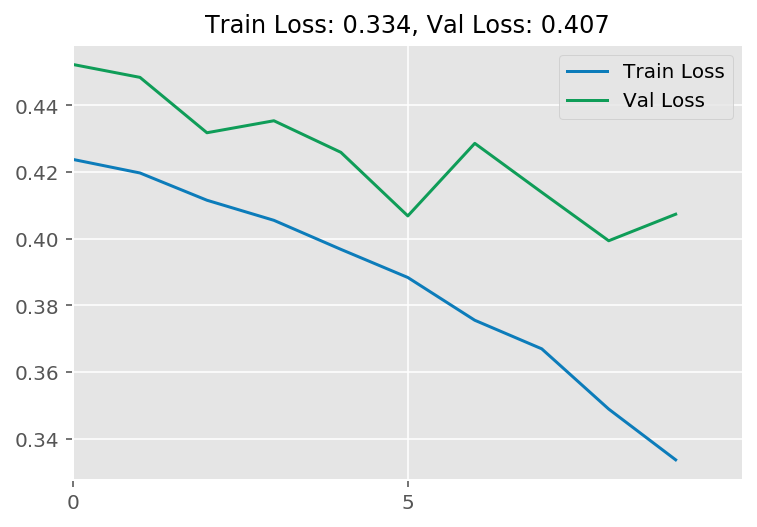

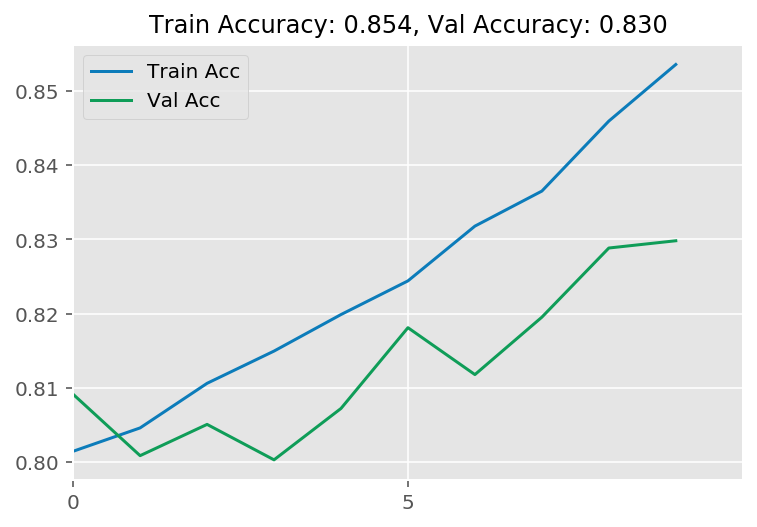

In [37]:
history = load_history('cat_vs_dog_history.bin')
plot_compare(history)